In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Url of first website
URL1 = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
#URL intercepted by postman containing the information we need of the first website
URL2 = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'

#Url of second website
URL3 = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
#URL intercepted by postman containing the information we need of the second website
URL4 = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

# 1. Showing the top-200 ranked universities of the first website

In [3]:
#Get-request on the first website
r = requests.get(URL2)
page = r.text
soup = BeautifulSoup(page, 'html.parser')
#convert to JSON format
Json_soup = json.loads(soup.text)

After various research on the data, we found this column data, that contains almost everything we need :

In [4]:
original_dataFrame = pd.DataFrame(Json_soup['data'])
#Getting only the columns we need
original_dataFrame = original_dataFrame[['uni', 'overall_rank', 'location', 'region']]

In [5]:
#GET ONLY THE 200 TOP RANKED UNI

#cast to int
first_dataFrame=original_dataFrame
first_dataFrame['overall_rank'] = first_dataFrame['overall_rank'].astype(int, copy=1)
# (< 201)-condition yields only 199  universities, so we use (< 202)
first_dataFrame = first_dataFrame[first_dataFrame.overall_rank < 202]
first_dataFrame = first_dataFrame.reset_index(drop=True)

In [6]:
#A function that returns the university URL from the element containing university info
def Decode_uni_url(elem):
    return 'https://www.topuniversities.com'+BeautifulSoup(elem, 'html.parser').find('a',href=True)['href']

In [7]:
#Creating Uni URL column
first_dataFrame['Uni URL'] = first_dataFrame['uni'].apply(Decode_uni_url)

In [8]:
#A function that returns the university name from the element containing university info
def Decode_uni_name(elem):
    return BeautifulSoup(elem, 'html.parser').find('a').decode_contents()

In [9]:
#Creating University Name column
first_dataFrame['University Name'] = first_dataFrame['uni'].apply(Decode_uni_name)
#Uni column have been decoded, and is no longer needed
del first_dataFrame['uni']

In [10]:
#rearange cols
cols = first_dataFrame.columns.tolist()
first_dataFrame = first_dataFrame[[cols[4],cols[0],cols[2],cols[1],cols[3]]]

Here below, we access each university individually through its URL and we get all our missing data.

Namely, Total faculty members, international faculty member, total students and international students.

In [11]:
#Function returns an element from a soup object of a university url objet at position n.
def getval(elemsoup, n):
    return int(elemsoup.find_all('div', {'class':'number'})[n].string.strip('\n').replace(',', ''))

In [12]:
#Getting all missing data

first_dataFrame['Total Fac. members']          = ""
first_dataFrame['International Fac. members'] = ""
first_dataFrame['Total students']              = ""
first_dataFrame['International students']     = ""

for i in range(len(first_dataFrame)):
    #A try except block was added to treat the cases where the numbers looked for are unavailable
    try:
            
        
        elem = first_dataFrame['Uni URL'][i]
        elemsoup = BeautifulSoup(requests.get(elem).text, 'html.parser')
        #It was noticed that university ranked 190 has information arranged differently, so it was handled manually.
        if(i==189) : 
            
            #No information about International Faculty members so it was set to 0
            first_dataFrame.loc[i,'International Fac. members'] = '0'
            first_dataFrame.loc[i,'Total Fac. members']          = getval(elemsoup, 0)
            first_dataFrame.loc[i,'International students']     = getval(elemsoup, 2)
            first_dataFrame.loc[i,'Total students']              = getval(elemsoup, 1)
        else : 
            first_dataFrame.loc[i,'International Fac. members'] = getval(elemsoup, 1)
            first_dataFrame.loc[i,'Total Fac. members']          = getval(elemsoup, 0)
            first_dataFrame.loc[i,'International students']     = getval(elemsoup, 3)
            first_dataFrame.loc[i,'Total students']              = getval(elemsoup, 2)
    except IndexError : 
        
        #If no such information is available simply put Nans.
        first_dataFrame.loc[i,'International Fac. members'] = np.nan
        first_dataFrame.loc[i,'Total Fac. members']          = np.nan
        first_dataFrame.loc[i,'International students']     = np.nan
        first_dataFrame.loc[i,'Total students']              = np.nan
        continue

#University URL is no longer needed after extracting all useful information
del first_dataFrame['Uni URL']

In [13]:
first_dataFrame

,University Name,overall_rank,region,location,Total Fac. members,International Fac. members,Total students,International students
0,Massachusetts Institute of Technology (MIT),1,North America,United States,2982,1679,11067,3717
1,Stanford University,2,North America,United States,4285,2042,15878,3611
2,Harvard University,3,North America,United States,4350,1311,22429,5266
3,California Institute of Technology (Caltech),4,North America,United States,953,350,2255,647
4,University of Cambridge,5,Europe,United Kingdom,5490,2278,18770,6699
5,University of Oxford,6,Europe,United Kingdom,6750,2964,19720,7353
6,UCL (University College London),7,Europe,United Kingdom,6345,2554,31080,14854
7,Imperial College London,8,Europe,United Kingdom,3930,2071,16090,8746
8,University of Chicago,9,North America,United States,2449,635,13557,3379
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,Switzerland,2477,1886,19815,7563


## 1.a Faculty members  to Student ratio : 

In [14]:
#Calculating faculty to student ratio.
first_dataFrame['ratio fac/stud'] = first_dataFrame['Total Fac. members'] / first_dataFrame['Total students']


In [15]:
#Sorting the resulting dataframe by faculty to student ratio
faculty_student_ratio=first_dataFrame.sort_values(by='ratio fac/stud',ascending= False )[['University Name','ratio fac/stud','overall_rank']]
faculty_student_ratio

,University Name,ratio fac/stud,overall_rank
3,California Institute of Technology (Caltech),0.422616,4
15,Yale University,0.398323,16
5,University of Oxford,0.342292,6
4,University of Cambridge,0.292488,5
16,Johns Hopkins University,0.276353,17
1,Stanford University,0.26987,2
0,Massachusetts Institute of Technology (MIT),0.26945,1
185,University of Rochester,0.266604,186
18,University of Pennsylvania,0.266437,19
17,Columbia University,0.247115,18


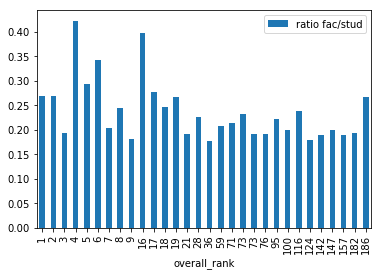

In [16]:
faculty_student_ratio[0:30].sort_index().plot(kind='bar',x='overall_rank')
plt.show()

We notice that universities from all over the ranking are in the top 30 in terms of faculty to student ratio.
This tells us that faculty to student ratio doesn't give much information about the ranking.

## 1.b International Student to Total students ratio : 

In [17]:
#Computing the international to total students ratio
first_dataFrame['ratio inter/total'] = first_dataFrame['International students'] / first_dataFrame['Total students']
inter_total_students=first_dataFrame.sort_values(by='ratio inter/total',ascending= False )[['University Name','ratio inter/total','overall_rank']]
inter_total_students

,University Name,ratio inter/total,overall_rank
34,London School of Economics and Political Scien...,0.691393,35
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047,12
7,Imperial College London,0.543567,8
198,Maastricht University,0.502533,200
46,Carnegie Mellon University,0.478062,47
6,UCL (University College London),0.477928,7
91,University of St Andrews,0.457955,92
41,The University of Melbourne,0.427434,41
126,Queen Mary University of London,0.421816,127
25,The University of Hong Kong,0.407144,26


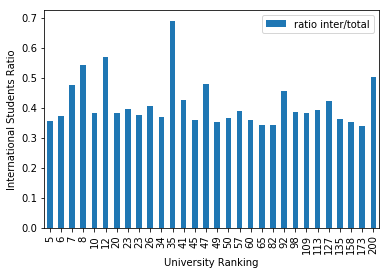

In [18]:
inter_total_students[0:30].sort_index().plot(kind='bar',x='overall_rank')
plt.xlabel('University Ranking')
plt.ylabel('International Students Ratio')
plt.show()

This graph also tells us that there's no telling where a university will be ranked from simply the international to total student ratio, since, the ranking of the first 30 universities in terms of international students pourcentage looks random.

## 1.c Aggregating by country : 

In [19]:
#Grouping by country
country_agg=first_dataFrame.groupby('location',as_index=False)[['Total Fac. members', 
                                                          'International Fac. members',
                                                          'Total students' ,
                                                          'International students']].sum()

### 1.c.a Faculty to student ratio by country : 

In [20]:
#Computing the faculty to student ratio by country
country_agg['ratio fac/stud'] = country_agg['Total Fac. members'] / country_agg['Total students']
country_student_ratio=country_agg.sort_values(by='ratio fac/stud',ascending= False )[['location','ratio fac/stud']]

#Deleting column after it was used
del country_agg['ratio fac/stud']
country_student_ratio

,location,ratio fac/stud
23,Russia,0.221910
8,Denmark,0.177261
24,Saudi Arabia,0.175828
25,Singapore,0.161530
18,Malaysia,0.153893
17,Japan,0.152479
27,South Korea,0.141721
30,Switzerland,0.140434
32,United Kingdom,0.136962
15,Israel,0.136047


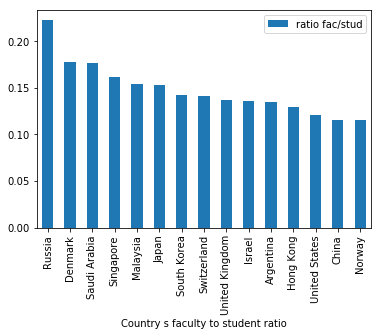

In [21]:
country_student_ratio[0:15].plot(kind='bar',x='location')
plt.xlabel('Country s faculty to student ratio')
plt.show()

We notice that, the countries with top ranked universities, with the exception of Singapoure, such as the United States, the United Kingdom, Switzerland, have a reasonable (not too high not too low) faculty to Student ratio.

### 1.c.b International to totals students ratio by country: 

In [22]:
#Computing the international students pourcentage
country_agg['ratio inter/total'] = country_agg['International students'] / country_agg['Total students']
inter_total_students=country_agg.sort_values(by='ratio inter/total',ascending= False )[['location','ratio inter/total']]

del country_agg['ratio inter/total']
inter_total_students

,location,ratio inter/total
1,Australia,0.352189
32,United Kingdom,0.341705
12,Hong Kong,0.310751
2,Austria,0.309980
30,Switzerland,0.302396
25,Singapore,0.276537
5,Canada,0.260161
21,New Zealand,0.258215
14,Ireland,0.235299
20,Netherlands,0.232980


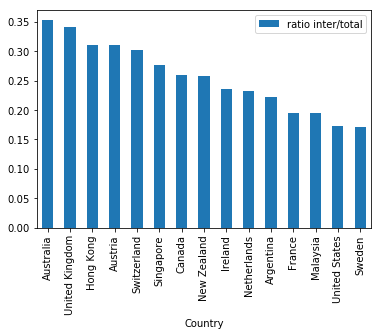

In [23]:
inter_total_students[0:15].plot(kind='bar',x='location')
plt.xlabel('Country')
plt.show()

From this graph, we notice that countries with well-ranked universities easily make it to the top 15 countries in terms of international students pourcentage.

## 1.d Aggregating by region : 

In [24]:
#Grouping by region
region_agg=first_dataFrame.groupby('region',as_index=False)[['Total Fac. members',
                                                       'International Fac. members',
                                                       'Total students' ,
                                                       'International students']].sum()

### 1.d.a Facutly to students ratio by region: 

In [25]:
#Computing faculty to student ratio
region_agg['ratio fac/students'] = region_agg['Total Fac. members'] / region_agg['Total students']
region_student_ratio=region_agg.sort_values(by='ratio fac/students',ascending= False )[['region','ratio fac/students']]


del region_agg['ratio fac/students']
region_student_ratio

,region,ratio fac/students
1,Asia,0.132260
4,North America,0.117776
2,Europe,0.111564
3,Latin America,0.104147
0,Africa,0.088450
5,Oceania,0.072385


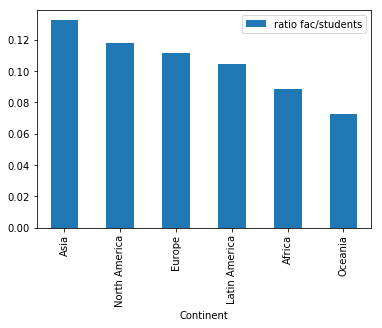

In [26]:
#Plotting
region_student_ratio.plot(kind='bar',x='region')
plt.xlabel('Continent')
plt.show()

We see that Oceania and Africa have the lowest Faculty to students ratio and Asia has the highest with more than 12%. But there isn't much of a difference between all the other continents with a ratio of slightly less than 12%.

### 1.d.b International to total students ratio by region:

In [27]:
#Computing the Internation students pourcentage
region_agg['ratio inter/total'] = region_agg['International students'] / region_agg['Total students']
region_student_ratio=region_agg.sort_values(by='ratio inter/total',ascending= False )[['region','ratio inter/total']]

del region_agg['ratio inter/total']
region_student_ratio

,region,ratio inter/total
5,Oceania,0.339261
2,Europe,0.229589
4,North America,0.188906
0,Africa,0.169703
1,Asia,0.136431
3,Latin America,0.084615


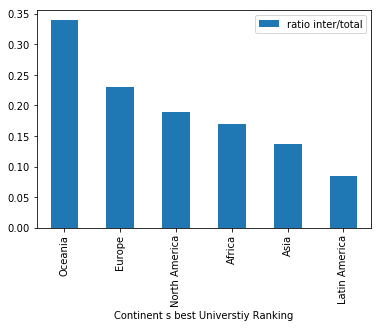

In [28]:
#Plotting
region_student_ratio.plot(kind='bar',x='region')
plt.xlabel('Continent s best Universtiy Ranking')
plt.show()

Oceania has the highest international students pourcentage for its top ranked universities. Europe and North America are respectively second and third. Africa, Asia and Latin America are last, which is a little expected.

# 2. Showing the top-200 ranked universities of the second website

In [29]:
#getting the second dataframe from URL4
r2=requests.get(URL4)
json2nd =json.loads(r2.text)

#All information we need is in the 'data' column.
second_dataFrame=pd.DataFrame(json2nd['data'])

#Extracting only the needed columns
second_dataFrame=second_dataFrame[['name','rank','location','stats_number_students','stats_student_staff_ratio','stats_pc_intl_students']]

Here below, we preprocess our needed columns for later computations. 

In [30]:
second_dataFrame['stats_student_staff_ratio']=second_dataFrame['stats_student_staff_ratio'].apply(
    lambda x : 1/float(x))
second_dataFrame['stats_pc_intl_students']=second_dataFrame['stats_pc_intl_students'].apply(
    lambda x : 0.01*float(x.replace('%','')))
second_dataFrame['stats_number_students']=second_dataFrame['stats_number_students'].apply(
    lambda x : int(x.replace(',','')))
second_dataFrame=second_dataFrame.rename(columns={
    'stats_number_students' : 'Number of Students',
    'stats_pc_intl_students':'International Students Ratio',
    'stats_student_staff_ratio':'Faculty Student Ratio'})
second_dataFrame=second_dataFrame[:200]

Here we compute all needed information using the data we have. For example, International students can be computed by number of students x International/total students ratio. And so on.

In [32]:
second_dataFrame['International Students'] = second_dataFrame['Number of Students']*second_dataFrame['International Students Ratio']
second_dataFrame['International Students'] = second_dataFrame['International Students'].apply(lambda x : int(x))
second_dataFrame['Total Staff'] = second_dataFrame['Number of Students']*second_dataFrame['Faculty Student Ratio']
second_dataFrame['Total Staff'] = second_dataFrame['Total Staff'].apply(lambda x : int(x))
second_dataFrame['rank']=second_dataFrame['rank'].apply(lambda x : x.replace('=',''))

In [33]:
second_dataFrame[['name','rank','location','International Students','Number of Students','Total Staff']]

,name,rank,location,International Students,Number of Students,Total Staff
0,University of Oxford,1,United Kingdom,7755,20409,1822
1,University of Cambridge,2,United Kingdom,6436,18389,1687
2,California Institute of Technology,3,United States,596,2209,339
3,Stanford University,3,United States,3485,15845,2112
4,Massachusetts Institute of Technology,5,United States,3800,11177,1284
5,Harvard University,6,United States,5284,20326,2283
6,Princeton University,7,United States,1909,7955,958
7,Imperial College London,8,United Kingdom,8721,15857,1390
8,University of Chicago,9,United States,3381,13525,2181
9,ETH Zurich – Swiss Federal Institute of Techno...,10,Switzerland,7308,19233,1317


## 2.a Facutly to student ratio : 

In [34]:
#Showing the top universities in terms of the faculty to student ratio
times_fac_ratio=second_dataFrame[['name','Faculty Student Ratio','rank']].sort_values(by='Faculty Student Ratio',ascending = False)
times_fac_ratio

,name,Faculty Student Ratio,rank
105,Vanderbilt University,0.303030,105
109,University of Copenhagen,0.243902,109
153,University of Rochester,0.232558,153
11,Yale University,0.232558,12
12,Johns Hopkins University,0.232558,13
97,Emory University,0.227273,98
16,Duke University,0.222222,17
114,École Polytechnique,0.196078,115
183,Scuola Normale Superiore di Pisa,0.192308,184
101,University of Pittsburgh,0.169492,100


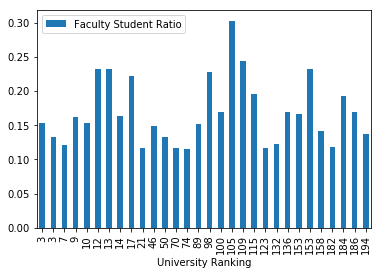

In [94]:
times_fac_ratio[0:30].sort_index().plot(kind='bar',x='rank')
plt.xlabel('University Ranking')
plt.show()

This plot shows that faculty to student ratio didn't play a role in the rankings.

## 2.b International students ratio

In [36]:
#Showing the top universities in terms of the International student pourcentage
times_inter_students_ratio=second_dataFrame[['name','International Students Ratio','rank']].sort_values(by='International Students Ratio',ascending = False)
times_inter_students_ratio

,name,International Students Ratio,rank
24,London School of Economics and Political Science,0.71,25
178,University of Luxembourg,0.57,179
37,École Polytechnique Fédérale de Lausanne,0.55,38
7,Imperial College London,0.55,8
102,Maastricht University,0.50,103
15,University College London,0.49,16
143,University of St Andrews,0.48,143
23,Carnegie Mellon University,0.45,24
120,Queen Mary University of London,0.45,121
39,University of Hong Kong,0.42,40


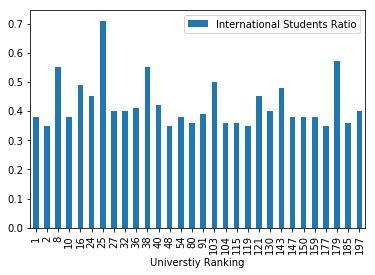

In [95]:
times_inter_students_ratio[0:30].sort_index().plot(kind='bar',x='rank')
plt.xlabel('Universtiy Ranking')
plt.show()

There seems to be more lower ranked universities in the top 30 in terms of international student ratio. which may suggest that, the international students ratio negatively affected the ranking.

## 2.c Grouping by country :

In [68]:
#Grouping By Country
country_times_dataFrame=second_dataFrame.groupby(by='location',as_index=False)[['Number of Students','International Students','Total Staff']].sum()

### 2.c.a faculty to student ratio by country : 

In [69]:
ratios=country_times_dataFrame
#Computing the Faculty to student ratio
ratios['Staff/Student']=ratios['Total Staff']/ratios['Number of Students']
#Computing the international student's pourcentage
ratios['Inter/Total Students']=ratios['International Students']/ratios['Number of Students']

#Deleting columns that are not needed anymore
del ratios['Number of Students']
del ratios['Total Staff']

In [70]:
#Showing top countries in terms of faculty to student ratio
fac_ratio_country=ratios[['location','Staff/Student']].sort_values(by='Staff/Student', ascending = False)
fac_ratio_country

,location,Staff/Student
5,Denmark,0.165278
17,Russia,0.136954
12,Japan,0.133331
11,Italy,0.130290
23,Switzerland,0.093165
26,United States,0.089308
24,Taiwan,0.086939
19,South Africa,0.085439
4,China,0.084234
7,France,0.074815


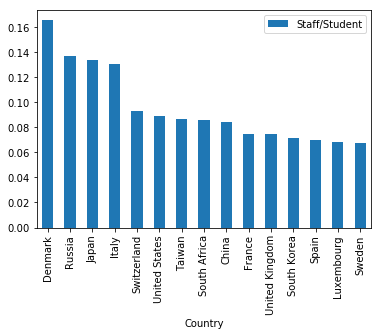

In [71]:
fac_ratio_country[0:15].plot(kind='bar',x='location')
plt.xlabel('Country')
plt.show()

Similarily to the previous dataframe, Danemark, Russia and Japan have some of the highest faculty to student ratio. And countries with highest ranked universities have reasonable ratios.

### 2.c.b Internation to total Students ratio by country : 

In [72]:
#Showing the countries with the biggest international students pourcentage
inter_ratio_country=ratios[['location','Inter/Total Students']].sort_values(by='Inter/Total Students', ascending = False)
inter_ratio_country

,location,Inter/Total Students
13,Luxembourg,0.569934
25,United Kingdom,0.357189
9,Hong Kong,0.323925
0,Australia,0.311979
18,Singapore,0.304522
23,Switzerland,0.303592
15,New Zealand,0.289970
10,Ireland,0.269976
1,Austria,0.259986
3,Canada,0.224145


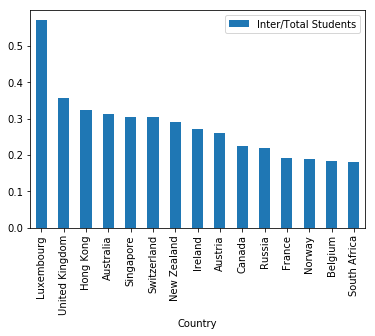

In [73]:
inter_ratio_country[0:15].plot(kind='bar',x='location')
plt.xlabel('Country')
plt.show()

United Kingdom , Australia, Singapoure and Switzerland have the highest pourcentage of international students similarily to the previous dataframe. But unlike the first dataframe, Luxembourg has by far the highest pourcentage.

## 2.d Grouping by region : 

Since there are no information about region in the second dataframe. We will have to find a region for each country using the associations in the first dataframe.

In [74]:
#Getting all regions from the raw dataframe loaded in the beginnning. 
regions=original_dataFrame[['region','location']].groupby('region')

#Extracting lists of countries of each region.
europe=list(np.unique(regions.get_group('Europe')['location']))
north_america=list(np.unique(regions.get_group('North America')['location']))
latin_america=list(np.unique(regions.get_group('Latin America')['location']))
africa=list(np.unique(regions.get_group('Africa')['location']))
asia=list(np.unique(regions.get_group('Asia')['location']))
oceania=list(np.unique(regions.get_group('Oceania')['location']))

#After exploring the times_dataFrame it was noticed that europe doesn't contain Luxembourg so it was manually added
europe.append('Luxembourg')

In [75]:
#A function that explores the lists created above to find a corresponding region of country passed as a parameter
def find_continent(country):
    
    if country in europe : return 'Europe'
    if country in north_america : return 'North America'
    if country in latin_america : return 'Latin America'
    if country in asia : return 'Asia'
    if country in africa : return 'Africa'
    if country in oceania : return 'Oceania'
    else : return 'No_region'

In [76]:

#We noticed that Russia was designated as Russian federation in the second dataframe. 
#So, we named it Russia to be consistent with the first dataframe.
second_dataFrame['location'][193]='Russia'
second_dataFrame['region'] = pd.Series(np.random.randn(len(second_dataFrame)))
second_dataFrame['region']=second_dataFrame['location'].apply(lambda x : find_continent(x) )

/Users/firasbenothman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
#Grouping by region
region_times_dataFrame=second_dataFrame.groupby('region',as_index=False)[['Number of Students'
                                                                   ,'International Students'
                                                                   ,'Total Staff']].sum()
#Creating the dataframes that will be needed to get staff/student ratios and international/total students ratio

ratios=region_times_dataFrame
ratios['Staff/Student']=ratios['Total Staff']/ratios['Number of Students']
ratios['Inter/Total Students']=ratios['International Students']/ratios['Number of Students']

#Deleting the columns that won't be needed anymore.
del ratios['Number of Students']
del ratios['Total Staff']

### 2.d.a Faculty to student ratio by region:

In [78]:
#Showing the faculty to student ratio by continent
fac_ratio_continent=ratios[['region','Staff/Student']].sort_values(by='Staff/Student', ascending = False)
fac_ratio_continent

,region,Staff/Student
0,Africa,0.085439
3,North America,0.084685
1,Asia,0.080286
2,Europe,0.059160
4,Oceania,0.038635


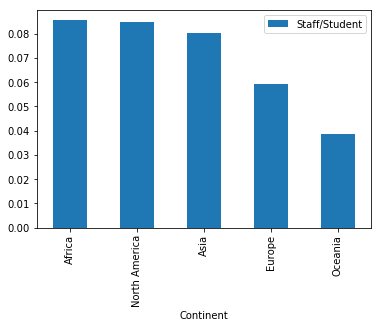

In [79]:
fac_ratio_continent.plot(kind='bar',x='region')
plt.xlabel('Continent')
plt.show()

There isn't much difference between continents in terms of faculty to student ratio.

### 2.d.b International to total students ratio by region : 

In [80]:
#Showing international students pourcentage
inter_ratio_continent=ratios[['region','Inter/Total Students']].sort_values(by='Inter/Total Students', ascending = False)
inter_ratio_continent

,region,Inter/Total Students
4,Oceania,0.309745
2,Europe,0.224634
0,Africa,0.179976
3,North America,0.171996
1,Asia,0.148464


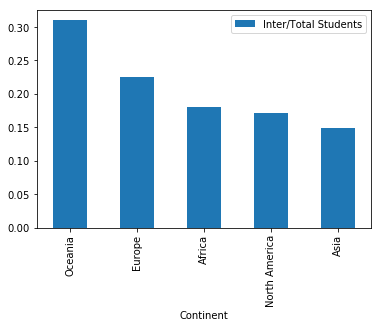

In [81]:
inter_ratio_continent.plot(kind='bar',x='region')
plt.xlabel('Continent')
plt.show()

In this dataframe Africa, surpasses North America in terms of International students Ratio.

# 3. Merging dataFrames : 

To merge the two dataframes by name, we decided to minimize different ways to write a university name.
For instance, Ecole Polytechnique Fédérale de Lausanne can also be written as Ecole Polytechnique Federale de Lausanne. And if we simply do the merge of the two dataframes, EPFL won't show on the merge dataframe.

So, First characters é were transformed into e.
Then, abbreviations were deleted from the university names whether they were written in between parenthesis or not. 
Then, all special characters and spaces were deleted and all letters were transformed to lowercase.
After that, all stop words and recurring words such as 'university' were deleted.
Finally, only the first 20 characters of the resulting string were kept to increase matching of same universities.

In [82]:
#This function deletes a block of capital letters, e.g. EPFL.

def capital_letters_block(letters) :
    position=-1
    most=0
    if(letters[0].isupper()) : tab=[letters[0]]
    else : tab=['']
    for i in range(1,len(letters)) : 
        if(letters[i].isupper() and letters[i-1].isupper()) : tab[len(tab)-1]+=letters[i]
        elif(letters[i].isupper()) : tab.append(letters[i]) 
    for i in range(len(tab)): 
        if(len(tab[i])>most) : 
            most=len(tab[i])
            position = i
    return tab[position]

In [83]:
#This function takes a university name as it is written in the dataframe 
#and deletes all characters other than the alphabet letters in lowercase.
def get_alphabet_only(name) : 
    alphabet=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    acc=''
    for i in range(len(name)) : 
        if(name[i] in alphabet) : acc+=name[i]
    return acc

In [84]:
#This function cleans up a university name

def cleanup(university) :
    
    #Take the characters É and e and transform them to E and e respectively.
    uni=university.replace('É','E')
    uni=uni.replace('é','e')
    
    
    #The block below deletes the parenthesis and what is in between if the length of what is between parenthesis is <10
    #It deletes the parenthesis and everything outside of the parenthesis otherwise.
    #For instance, Ecole Polytechnique Federale de Lausanne (EPFL) => after this block, we get Ecole Polytechnique Federale de Lausanne.
    # And if we have : EPFL (Ecole Polytechnique Federale de Lausanne) => after this block , we get Ecole Polytechnique Federale de Lausanne.
    #-----------------------------------------------------------------#
    start = uni.find( '(' )
    end = uni.find( ')' )
    result=''
    
    if start != -1 and end != -1:
        result = uni[start+1:end]
        if(len(result)<10):
            uni=uni.replace('('+result+')','')
        else : uni=result
            
    #-----------------------------------------------------------------#
    
    #Here, we detect capital blocks that have length 2<=length<=5 and delete it.
    block=capital_letters_block(uni)
    if(len(block)<=5 and len(block)>=2):
        uni=uni.replace(block,'')
    
    #Here we make everything to lowercase and delete certain recurring stop words such as at, the, of etc ...
    #Also we delete spaces and special characters and the word university.
    uni=uni.lower()
    uni=get_alphabet_only(uni)
    uni=uni.replace('university','')
    uni=uni.replace('zu','')
    uni=uni.replace('of','')
    uni=uni.replace('the','')
    uni=uni.replace('at','')
    uni=uni.replace(' ','')
    #We take the 20 first characters of the result to increase drastically the chances of same universities having same result from this function.
    uni=uni[:20]
    return uni

In [85]:
#Renaming columns to get the desired results after merge.
second_dataFrame=second_dataFrame.rename(columns={'rank':'rank_2'})
first_dataFrame=first_dataFrame.rename(columns={'overall_rank':'rank_1','University Name':'name'})

In [86]:
#Cleaning up the names to increase chances of matching.
second_dataFrame['clean_name']=second_dataFrame['name'].apply(lambda x : cleanup(x))
first_dataFrame['clean_name']=first_dataFrame['name'].apply(lambda x : cleanup(x))

In [87]:
#Merging 
merged_frames=pd.merge(first_dataFrame[['name','rank_1','location','Total students','International students','Total Fac. members','International Fac. members','clean_name','ratio inter/total','ratio fac/stud']],second_dataFrame[['rank_2','location','clean_name']], on=['clean_name','location'])
merged_frames[['name','rank_1','rank_2','location','Total students','International students','Total Fac. members','International Fac. members']]

,name,rank_1,rank_2,location,Total students,International students,Total Fac. members,International Fac. members
0,Massachusetts Institute of Technology (MIT),1,5,United States,11067,3717,2982,1679
1,Stanford University,2,3,United States,15878,3611,4285,2042
2,Harvard University,3,6,United States,22429,5266,4350,1311
3,California Institute of Technology (Caltech),4,3,United States,2255,647,953,350
4,University of Cambridge,5,2,United Kingdom,18770,6699,5490,2278
5,University of Oxford,6,1,United Kingdom,19720,7353,6750,2964
6,UCL (University College London),7,16,United Kingdom,31080,14854,6345,2554
7,Imperial College London,8,8,United Kingdom,16090,8746,3930,2071
8,University of Chicago,9,9,United States,13557,3379,2449,635
9,ETH Zurich - Swiss Federal Institute of Techno...,10,10,Switzerland,19815,7563,2477,1886


In [88]:
#Deleting clean name column since it not needed anymore
del merged_frames['clean_name']
del first_dataFrame['clean_name']
del second_dataFrame['clean_name']

# 4. Exploratory analysis :

In [89]:
correlations=merged_frames.copy().dropna()
correlations['rank_2']=correlations['rank_2'].apply(lambda x :float(x) )
correlations['Total students']=correlations['Total students'].apply(lambda x :float(x) )
correlations['Total Fac. members']=correlations['Total Fac. members'].apply(lambda x :float(x) )
correlations['International students']=correlations['International students'].apply(lambda x :float(x) )
correlations['International Fac. members']=correlations['International Fac. members'].apply(lambda x :float(x) )
correlations['ratio inter/total']=correlations['ratio inter/total'].apply(lambda x :float(x) )
correlations['ratio fac/stud']=correlations['ratio fac/stud'].apply(lambda x :float(x) )

correlations=correlations[['rank_1','rank_2',
               'Total students','International students',
               'Total Fac. members','International Fac. members','ratio inter/total','ratio fac/stud']].corr()
correlations

,rank_1,rank_2,Total students,International students,Total Fac. members,International Fac. members,ratio inter/total,ratio fac/stud
rank_1,1.000000,0.684184,-0.060027,-0.248569,-0.361587,-0.491921,-0.291091,-0.380940
rank_2,0.684184,1.000000,-0.202389,-0.277864,-0.385417,-0.375436,-0.219586,-0.301370
Total students,-0.060027,-0.202389,1.000000,0.655249,0.620861,0.333872,-0.172585,-0.397222
International students,-0.248569,-0.277864,0.655249,1.000000,0.426856,0.585725,0.531570,-0.244270
Total Fac. members,-0.361587,-0.385417,0.620861,0.426856,1.000000,0.652146,-0.084286,0.337603
International Fac. members,-0.491921,-0.375436,0.333872,0.585725,0.652146,1.000000,0.369942,0.304505
ratio inter/total,-0.291091,-0.219586,-0.172585,0.531570,-0.084286,0.369942,1.000000,0.083076
ratio fac/stud,-0.380940,-0.301370,-0.397222,-0.244270,0.337603,0.304505,0.083076,1.000000


From this correlation matrix we see:

- That rank_1 is positively correlated to rank_2 which makes sense, since a well ranked university in one list should also be well-ranked in another, and vice versa.

- Total faculty members is positively correlated to the total number of students. That also makes sense, because, more students require more faculty members.

- The international students ratio is negatively correlated to both rankings, which suggests that the more pourcentage of international students a universtiy has the less likely it will have a good ranking. However, it is worth noting that with a correlation factor of -0.29 and -0.22, this is not a very strong relation. 

- Faculty to students ratio is also negatively correlated to both rankings, => more faculty to student ratio more likely a university will be ranked lower.

- International Faculty members is positively correlated to international student numbers, which suggests that universities that are open to more international students is also open to more international faculty members.

- International faculty members is surprisingly negatively correlated to both rankings.

# 5. Finding new ranking :

Here, what was done was simply compute the mean of the two rankings, and return the resulting new rank.

In [90]:
#Computing the mean
mean_merged_frames=merged_frames
mean_merged_frames['rank_2']=mean_merged_frames['rank_2'].apply(lambda x :int(x) )
mean_merged_frames['mean_rank']=0.5*(merged_frames['rank_1']+merged_frames['rank_2'])

#Deleting rank_1 and rank_2 from mean_merged_frames
del mean_merged_frames['rank_1']
del mean_merged_frames['rank_2']

In [91]:
#Sorting universities by new rank.
mean_merged_frames=mean_merged_frames.sort_values(by='mean_rank').reset_index(drop=True)

In [92]:
#This function returns a ranking from the sorted new dataframe 
#and more importantly, takes into consideration ties between universities.

def return_new_rank(table):
    index=1
    rankings=[1]
    current=1
    repetitions=1
    while(index < len(table)) : 
        if(table[index]==table[index-1]):
            rankings.append(current)
            repetitions+=1
        else : 
            rankings.append(current+repetitions) 
            current+=repetitions
            repetitions=1
        index+=1
    return rankings

In [93]:
#Showing the new ranking.
mean_merged_frames['new_rank']= return_new_rank(sorted(mean_merged_frames['mean_rank']))
mean_merged_frames=mean_merged_frames[['name','new_rank'
                                       ,'location','Total students'
                                       ,'International students','Total Fac. members'
                                       ,'International Fac. members','mean_rank']]
mean_merged_frames

,name,new_rank,location,Total students,International students,Total Fac. members,International Fac. members,mean_rank
0,Stanford University,1,United States,15878,3611,4285,2042,2.5
1,Massachusetts Institute of Technology (MIT),2,United States,11067,3717,2982,1679,3.0
2,California Institute of Technology (Caltech),3,United States,2255,647,953,350,3.5
3,University of Cambridge,3,United Kingdom,18770,6699,5490,2278,3.5
4,University of Oxford,3,United Kingdom,19720,7353,6750,2964,3.5
5,Harvard University,6,United States,22429,5266,4350,1311,4.5
6,Imperial College London,7,United Kingdom,16090,8746,3930,2071,8.0
7,University of Chicago,8,United States,13557,3379,2449,635,9.0
8,ETH Zurich - Swiss Federal Institute of Techno...,9,Switzerland,19815,7563,2477,1886,10.0
9,Princeton University,9,United States,8069,1793,1007,246,10.0
